In [53]:
# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader
# from transformers import AutoTokenizer
# from torch.nn.utils.rnn import pad_sequence
# from tqdm import tqdm
# import numpy as np


# # 2. Load Khmer tokenizer

# tokenizer = AutoTokenizer.from_pretrained("khopilot/km-tokenizer-khmer", use_fast=False)
# vocab_size = tokenizer.vocab_size
# pad_token_id = tokenizer.pad_token_id
# print("Tokenizer vocab size:", vocab_size)

In [54]:
# dataset_path = r"D:\AMS_Year5\Semester_1\TP_IWR\Khmer-Text-Prediction\dataset\cleaned_txt\clean_khmer.txt"
# with open(dataset_path, "r", encoding="utf-8") as f:
#     sentences = [line.strip() for line in f if line.strip()]

# print(f"Loaded {len(sentences)} sentences.")

In [55]:
# # Tokenize sentences
# tokenized_lengths = [len(tokenizer.encode(s, add_special_tokens=False)) for s in sentences]

# import matplotlib.pyplot as plt

# plt.hist(tokenized_lengths, bins=50)
# plt.xlabel("Token length per sentence")
# plt.ylabel("Number of sentences")
# plt.title("Distribution of Khmer sentence lengths")
# plt.show()

# print("Max length:", max(tokenized_lengths))
# print("Mean length:", np.mean(tokenized_lengths))
# print("Median length:", np.median(tokenized_lengths))


<h1 align="center">Bidirectional LSTM</h1>

In [56]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np


In [ ]:
MAX_SEQ_LEN = 60
STRIDE = 20                 # overlap
BATCH_SIZE = 64
EPOCHS = 50
TOP_K = 5
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 2
LR = 0.001


1. Load tokenizer (Khmer)

In [58]:

tokenizer = AutoTokenizer.from_pretrained(
    "khopilot/km-tokenizer-khmer",
    use_fast=False
)

VOCAB_SIZE = tokenizer.vocab_size
PAD_ID = tokenizer.pad_token_id


2. Load dataset (one sentence per line)

In [59]:
with open(r"D:\AMS_Year5\Semester_1\TP_IWR\Khmer-Text-Prediction\dataset\cleaned_txt\clean_khmer.txt", "r", encoding="utf-8") as f:
    sentences = [line.strip() for line in f if line.strip()]

print(f"Total sentences: {len(sentences)}")


Total sentences: 39558


3. Train / Validation / Test split (sentence-level)

In [60]:
train_sentences, temp_sentences = train_test_split(
    sentences, test_size=0.2, random_state=42
)

val_sentences, test_sentences = train_test_split(
    temp_sentences, test_size=0.5, random_state=42
)

print(f"Train: {len(train_sentences)}")
print(f"Val:   {len(val_sentences)}")
print(f"Test:  {len(test_sentences)}")


Train: 31646
Val:   3956
Test:  3956


4. Create sequences with sliding window

In [61]:
def create_sequences(sentences):
    sequences = []

    for sentence in sentences:
        ids = tokenizer.encode(sentence, add_special_tokens=False)

        if len(ids) < 2:
            continue

        for start in range(0, len(ids) - 1, STRIDE):
            end = start + MAX_SEQ_LEN
            input_seq = ids[start:end]

            if len(input_seq) < 1:
                continue

            target_index = min(end, len(ids) - 1)
            target = ids[target_index]

            sequences.append((input_seq, target))

    return sequences


In [62]:
train_sequences = create_sequences(train_sentences)
val_sequences   = create_sequences(val_sentences)
test_sequences  = create_sequences(test_sentences)

print("Train sequences:", len(train_sequences))
print("Val sequences:", len(val_sequences))
print("Test sequences:", len(test_sequences))


Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors


Train sequences: 86188
Val sequences: 11148
Test sequences: 10781


5. Dataset & collate_fn

In [63]:
class KhmerDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        x, y = self.sequences[idx]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)


In [64]:
def collate_fn(batch):
    inputs, targets = zip(*batch)
    inputs = pad_sequence(inputs, batch_first=True, padding_value=PAD_ID)
    targets = torch.stack(targets)
    return inputs, targets


6. DataLoaders

In [65]:
train_dataset = KhmerDataset(train_sequences)
val_dataset   = KhmerDataset(val_sequences)
test_dataset  = KhmerDataset(test_sequences)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE,
    shuffle=True, collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE,
    shuffle=False, collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE,
    shuffle=False, collate_fn=collate_fn
)


7. BiLSTM Model (PyTorch nn.LSTM)

In [66]:
class BiLSTM(nn.Module):
    def __init__(self):
        super().__init__()

        self.embedding = nn.Embedding(
            VOCAB_SIZE, EMBED_SIZE, padding_idx=PAD_ID
        )

        self.lstm = nn.LSTM(
            EMBED_SIZE,
            HIDDEN_SIZE,
            num_layers=NUM_LAYERS,
            batch_first=True,
            bidirectional=True,
            dropout=0.2
        )

        self.fc = nn.Linear(HIDDEN_SIZE * 2, VOCAB_SIZE)

    def forward(self, x):
        x = self.embedding(x)
        outputs, _ = self.lstm(x)
        logits = self.fc(outputs[:, -1, :])
        return logits


8. Training setup

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BiLSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


9. Evaluation function (Loss + PPL + Top-K)

In [68]:
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    correct_topk = 0
    total = 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item()

            topk = torch.topk(outputs, TOP_K, dim=1).indices
            for i in range(y.size(0)):
                if y[i] in topk[i]:
                    correct_topk += 1
                total += 1

    avg_loss = total_loss / len(dataloader)
    perplexity = np.exp(avg_loss)
    topk_acc = correct_topk / total

    return avg_loss, perplexity, topk_acc


10. Training loop (with validation)

In [69]:
train_losses = []
val_losses = []

train_ppls = []
val_ppls = []

val_top5_accs = []


In [70]:
PATIENCE = 20              # how many epochs to wait
best_val_loss = float("inf")
patience_counter = 0



for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_loss = total_loss / len(train_loader)
    train_ppl = np.exp(train_loss)

    val_loss, val_ppl, val_topk = evaluate(model, val_loader)

    print(
        f"Epoch {epoch+1} | "
        f"Train Loss {train_loss:.4f} PPL {train_ppl:.2f} | "
        f"Val Loss {val_loss:.4f} PPL {val_ppl:.2f} | "
        f"Val Top-{TOP_K} {val_topk:.4f}"
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    train_ppls.append(train_ppl)
    val_ppls.append(val_ppl)

    val_top5_accs.append(val_topk)


    # EARLY STOPPING LOGIC

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

        #  Save BEST model
        torch.save(model.state_dict(), "bilstm_best.pth")
    else:
        patience_counter += 1
        print(f"EarlyStopping counter: {patience_counter}/{PATIENCE}")

        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break



Epoch 1: 100%|██████████| 1347/1347 [00:40<00:00, 33.36it/s]


Epoch 1 | Train Loss 6.1563 PPL 471.70 | Val Loss 5.3468 PPL 209.93 | Val Top-5 0.2936


Epoch 2: 100%|██████████| 1347/1347 [00:40<00:00, 33.41it/s]


Epoch 2 | Train Loss 4.3522 PPL 77.65 | Val Loss 4.1616 PPL 64.18 | Val Top-5 0.4811


Epoch 3: 100%|██████████| 1347/1347 [00:39<00:00, 33.75it/s]


Epoch 3 | Train Loss 2.8806 PPL 17.83 | Val Loss 3.2363 PPL 25.44 | Val Top-5 0.6320


Epoch 4: 100%|██████████| 1347/1347 [00:39<00:00, 34.01it/s]


Epoch 4 | Train Loss 1.7793 PPL 5.93 | Val Loss 2.9153 PPL 18.45 | Val Top-5 0.6911


Epoch 5: 100%|██████████| 1347/1347 [00:39<00:00, 33.82it/s]


Epoch 5 | Train Loss 1.2284 PPL 3.42 | Val Loss 2.8915 PPL 18.02 | Val Top-5 0.7086


Epoch 6: 100%|██████████| 1347/1347 [00:38<00:00, 34.98it/s]


Epoch 6 | Train Loss 0.8091 PPL 2.25 | Val Loss 2.9545 PPL 19.19 | Val Top-5 0.7204
EarlyStopping counter: 1/20


Epoch 7: 100%|██████████| 1347/1347 [00:40<00:00, 33.60it/s]


Epoch 7 | Train Loss 0.5114 PPL 1.67 | Val Loss 3.0491 PPL 21.10 | Val Top-5 0.7223
EarlyStopping counter: 2/20


Epoch 8: 100%|██████████| 1347/1347 [00:39<00:00, 34.44it/s]


Epoch 8 | Train Loss 0.3398 PPL 1.40 | Val Loss 3.1923 PPL 24.34 | Val Top-5 0.7184
EarlyStopping counter: 3/20


Epoch 9: 100%|██████████| 1347/1347 [00:39<00:00, 33.78it/s]


Epoch 9 | Train Loss 0.1811 PPL 1.20 | Val Loss 3.3109 PPL 27.41 | Val Top-5 0.7209
EarlyStopping counter: 4/20


Epoch 10: 100%|██████████| 1347/1347 [00:39<00:00, 33.80it/s]


Epoch 10 | Train Loss 0.1164 PPL 1.12 | Val Loss 3.4246 PPL 30.71 | Val Top-5 0.7189
EarlyStopping counter: 5/20


Epoch 11: 100%|██████████| 1347/1347 [00:39<00:00, 33.82it/s]


Epoch 11 | Train Loss 0.1420 PPL 1.15 | Val Loss 3.4668 PPL 32.03 | Val Top-5 0.7208
EarlyStopping counter: 6/20


Epoch 12: 100%|██████████| 1347/1347 [00:39<00:00, 34.01it/s]


Epoch 12 | Train Loss 0.0966 PPL 1.10 | Val Loss 3.5467 PPL 34.70 | Val Top-5 0.7196
EarlyStopping counter: 7/20


Epoch 13: 100%|██████████| 1347/1347 [00:39<00:00, 34.05it/s]


Epoch 13 | Train Loss 0.0807 PPL 1.08 | Val Loss 3.6140 PPL 37.11 | Val Top-5 0.7146
EarlyStopping counter: 8/20


Epoch 14: 100%|██████████| 1347/1347 [00:38<00:00, 34.55it/s]


Epoch 14 | Train Loss 0.1019 PPL 1.11 | Val Loss 3.6358 PPL 37.93 | Val Top-5 0.7199
EarlyStopping counter: 9/20


Epoch 15: 100%|██████████| 1347/1347 [00:39<00:00, 34.35it/s]


Epoch 15 | Train Loss 0.0707 PPL 1.07 | Val Loss 3.7245 PPL 41.45 | Val Top-5 0.7204
EarlyStopping counter: 10/20


Epoch 16: 100%|██████████| 1347/1347 [00:39<00:00, 34.36it/s]


Epoch 16 | Train Loss 0.0638 PPL 1.07 | Val Loss 3.7544 PPL 42.71 | Val Top-5 0.7182
EarlyStopping counter: 11/20


Epoch 17: 100%|██████████| 1347/1347 [00:39<00:00, 33.75it/s]


Epoch 17 | Train Loss 0.0761 PPL 1.08 | Val Loss 3.7572 PPL 42.83 | Val Top-5 0.7192
EarlyStopping counter: 12/20


Epoch 18: 100%|██████████| 1347/1347 [00:40<00:00, 33.66it/s]


Epoch 18 | Train Loss 0.0694 PPL 1.07 | Val Loss 3.8160 PPL 45.42 | Val Top-5 0.7179
EarlyStopping counter: 13/20


Epoch 19: 100%|██████████| 1347/1347 [00:39<00:00, 33.75it/s]


Epoch 19 | Train Loss 0.0600 PPL 1.06 | Val Loss 3.8541 PPL 47.19 | Val Top-5 0.7182
EarlyStopping counter: 14/20


Epoch 20: 100%|██████████| 1347/1347 [00:40<00:00, 33.08it/s]


Epoch 20 | Train Loss 0.0676 PPL 1.07 | Val Loss 3.8891 PPL 48.87 | Val Top-5 0.7178
EarlyStopping counter: 15/20


Epoch 21: 100%|██████████| 1347/1347 [00:39<00:00, 33.68it/s]


Epoch 21 | Train Loss 0.0542 PPL 1.06 | Val Loss 3.9607 PPL 52.49 | Val Top-5 0.7177
EarlyStopping counter: 16/20


Epoch 22: 100%|██████████| 1347/1347 [00:39<00:00, 33.68it/s]


Epoch 22 | Train Loss 0.0606 PPL 1.06 | Val Loss 3.9538 PPL 52.13 | Val Top-5 0.7160
EarlyStopping counter: 17/20


Epoch 23: 100%|██████████| 1347/1347 [00:38<00:00, 34.71it/s]


Epoch 23 | Train Loss 0.0575 PPL 1.06 | Val Loss 4.0095 PPL 55.12 | Val Top-5 0.7162
EarlyStopping counter: 18/20


Epoch 24: 100%|██████████| 1347/1347 [00:39<00:00, 33.85it/s]


Epoch 24 | Train Loss 0.0559 PPL 1.06 | Val Loss 4.0315 PPL 56.34 | Val Top-5 0.7151
EarlyStopping counter: 19/20


Epoch 25: 100%|██████████| 1347/1347 [00:39<00:00, 34.25it/s]


Epoch 25 | Train Loss 0.0625 PPL 1.06 | Val Loss 4.0259 PPL 56.03 | Val Top-5 0.7182
EarlyStopping counter: 20/20
Early stopping triggered.


In [71]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)


+ Loss

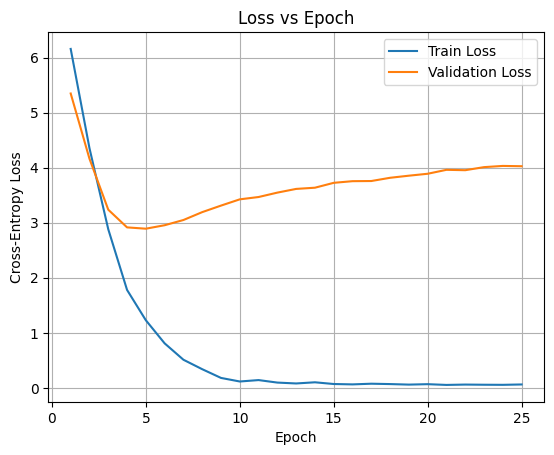

In [72]:
plt.figure()
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.grid(True)
plt.show()


+ Perplexity (LOG SCALE)

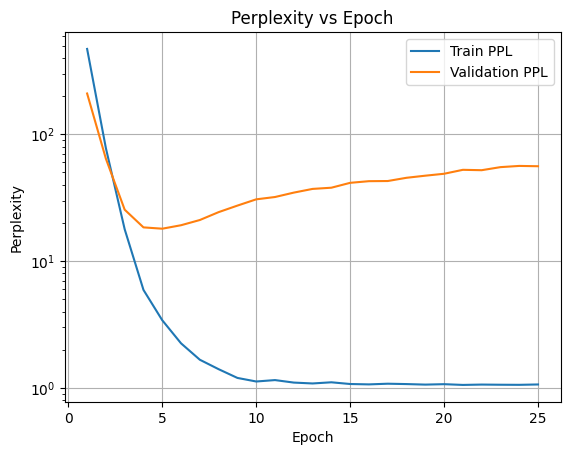

In [73]:
plt.figure()
plt.plot(epochs, train_ppls, label="Train PPL")
plt.plot(epochs, val_ppls, label="Validation PPL")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.yscale("log")
plt.title("Perplexity vs Epoch")
plt.legend()
plt.grid(True)
plt.show()


+ Validation Top-5 Accuracy

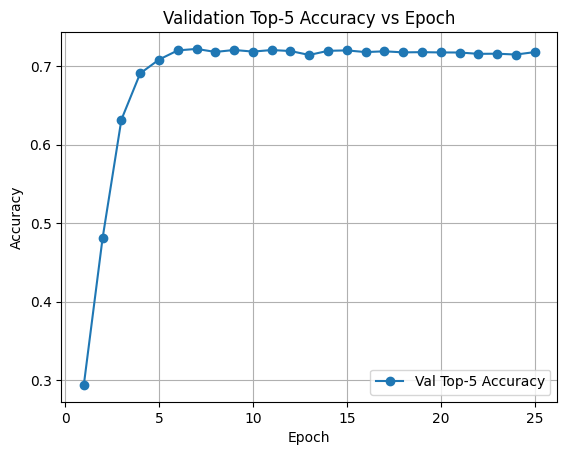

In [74]:
plt.figure()
plt.plot(epochs, val_top5_accs, marker="o", label="Val Top-5 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Top-5 Accuracy vs Epoch")
plt.legend()
plt.grid(True)
plt.show()


11. Final Test Evaluation

In [75]:
test_loss, test_ppl, test_topk = evaluate(model, test_loader)

print("\nFINAL TEST RESULTS")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Perplexity: {test_ppl:.2f}")
print(f"Test Top-{TOP_K} Accuracy: {test_topk:.4f}")



FINAL TEST RESULTS
Test Loss: 3.8805
Test Perplexity: 48.45
Test Top-5 Accuracy: 0.7282


12. Save model & tokenizer

In [76]:
torch.save(model.state_dict(), r"D:\AMS_Year5\Semester_1\TP_IWR\Khmer-Text-Prediction\Trained_Model\BiLSTM\bilstm_khmer.pth")
tokenizer.save_pretrained(r"D:\AMS_Year5\Semester_1\TP_IWR\Khmer-Text-Prediction\Trained_Model\BiLSTM\km-tokenizer-khmer")

print("Model and tokenizer saved successfully.")


Model and tokenizer saved successfully.


<h1 align="center">Full DataFlow</h1>

**Step 1: Raw Khmer Text**  
`ខ្ញុំ ឈ្មោះ សុខ លីន`

---

**Step 2: Tokenization (Earlier Stage)**  
```python
['ខ្ញុំ', 'ឈ្មោះ', 'សុខ', 'លីន']


**Step 3: SentencePiece Encoding**  
```python
[345, 981, 1203, 451]

**Step 4: Training Pair Creation (Next-Token Prediction)**
| Input Sequence     | Target |
| ------------------ | ------ |
| `[345]`            | `981`  |
| `[345, 981]`       | `1203` |
| `[345, 981, 1203]` | `451`  |


**Step 5: Padding (Fixed Length Example)**

Pad with 0 to ensure equal-length sequences.
```python
# fixed length = 6
[0, 0, 0, 345, 981, 1203]


**Step 6: Embedding Layer**

Token IDs → Dense vectors (256 dimensions)

```python
Input: [345, 981, 1203]

Output: [vec_256, vec_256, vec_256]

**Step 7: BiLSTM Layer**

+ Forward context (left → right)

+ Backward context (right → left)

+ Concatenation of hidden states

**Step 8: Output Layer**


Combined hidden state → vocabulary-sized logits → softmax probability distribution

**Step 9: Prediction (Top-5 Next-Word Suggestions)**

```python
1) <word_A>  (p=0.31)
2) <word_B>  (p=0.18)
3) <word_C>  (p=0.12)
4) <word_D>  (p=0.09)
5) <word_E>  (p=0.07)



**Metrics Used**
| Metric             | Purpose                       |
| ------------------ | ----------------------------- |
| Cross-Entropy Loss | Training objective            |
| Perplexity         | Fluency / uncertainty measure |
| Accuracy@5         | Keyboard suggestion quality   |


<h1 align="center">LSTM</h1>

In [77]:
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(VOCAB_SIZE, EMBED_SIZE, padding_idx=PAD_ID)
        self.lstm = nn.LSTM(
            input_size=EMBED_SIZE,
            hidden_size=HIDDEN_SIZE,
            num_layers=NUM_LAYERS,
            batch_first=True,
            bidirectional=False,   
            dropout=0.2
        )
        self.fc = nn.Linear(HIDDEN_SIZE, VOCAB_SIZE)  

    def forward(self, x):
        x = self.embedding(x)
        outputs, _ = self.lstm(x)
        logits = self.fc(outputs[:, -1, :])
        return logits


In [78]:
# Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [79]:
print(device)

cuda


In [80]:
# Early stopping setup
PATIENCE = 20
best_val_loss = float("inf")
patience_counter = 0


In [81]:
# Metric logging for plotting
train_losses = []
val_losses = []
train_ppls = []
val_ppls = []
val_top5_accs = []


In [82]:
# Evaluation function
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    correct_topk = 0
    total = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item()

            # Top-K accuracy
            topk = torch.topk(outputs, 5, dim=1).indices
            for i in range(y.size(0)):
                if y[i] in topk[i]:
                    correct_topk += 1
                total += 1

    avg_loss = total_loss / len(dataloader)
    ppl = np.exp(avg_loss)
    top5_acc = correct_topk / total
    return avg_loss, ppl, top5_acc



In [ ]:
# Training loop 
EPOCHS = 50
TOP_K = 5

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Calculate train metrics
    train_loss = total_loss / len(train_loader)
    train_ppl = np.exp(train_loss)

    # Evaluate on validation set
    val_loss, val_ppl, val_topk = evaluate(model, val_loader)

    print(
        f"Epoch {epoch+1} | "
        f"Train Loss {train_loss:.4f} PPL {train_ppl:.2f} | "
        f"Val Loss {val_loss:.4f} PPL {val_ppl:.2f} | "
        f"Val Top-{TOP_K} {val_topk:.4f}"
    )

    # Log metrics for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_ppls.append(train_ppl)
    val_ppls.append(val_ppl)
    val_top5_accs.append(val_topk)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), "lstm_best.pth")
    else:
        patience_counter += 1
        print(f"EarlyStopping counter: {patience_counter}/{PATIENCE}")
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break




Epoch 1: 100%|██████████| 1347/1347 [00:19<00:00, 69.70it/s]


Epoch 1 | Train Loss 6.3674 PPL 582.56 | Val Loss 5.8150 PPL 335.30 | Val Top-5 0.2316


Epoch 2: 100%|██████████| 1347/1347 [00:19<00:00, 69.20it/s]


Epoch 2 | Train Loss 5.0454 PPL 155.31 | Val Loss 4.5059 PPL 90.55 | Val Top-5 0.4207


Epoch 3: 100%|██████████| 1347/1347 [00:19<00:00, 69.80it/s]


Epoch 3 | Train Loss 3.5415 PPL 34.52 | Val Loss 3.3750 PPL 29.23 | Val Top-5 0.5959


Epoch 4: 100%|██████████| 1347/1347 [00:19<00:00, 69.38it/s]


Epoch 4 | Train Loss 2.3878 PPL 10.89 | Val Loss 2.9648 PPL 19.39 | Val Top-5 0.6572


Epoch 5: 100%|██████████| 1347/1347 [00:19<00:00, 67.94it/s]


Epoch 5 | Train Loss 1.7463 PPL 5.73 | Val Loss 2.8192 PPL 16.76 | Val Top-5 0.6846


Epoch 6: 100%|██████████| 1347/1347 [00:19<00:00, 68.87it/s]


Epoch 6 | Train Loss 1.2845 PPL 3.61 | Val Loss 2.8078 PPL 16.57 | Val Top-5 0.7015


Epoch 7: 100%|██████████| 1347/1347 [00:19<00:00, 70.66it/s]


Epoch 7 | Train Loss 0.8937 PPL 2.44 | Val Loss 2.8654 PPL 17.56 | Val Top-5 0.7078
EarlyStopping counter: 1/20


Epoch 8: 100%|██████████| 1347/1347 [00:19<00:00, 70.64it/s]


Epoch 8 | Train Loss 0.5764 PPL 1.78 | Val Loss 2.9448 PPL 19.01 | Val Top-5 0.7077
EarlyStopping counter: 2/20


Epoch 9: 100%|██████████| 1347/1347 [00:18<00:00, 71.49it/s]


Epoch 9 | Train Loss 0.3630 PPL 1.44 | Val Loss 3.0263 PPL 20.62 | Val Top-5 0.7084
EarlyStopping counter: 3/20


Epoch 10: 100%|██████████| 1347/1347 [00:18<00:00, 71.38it/s]


Epoch 10 | Train Loss 0.2391 PPL 1.27 | Val Loss 3.1200 PPL 22.65 | Val Top-5 0.7083
EarlyStopping counter: 4/20


Epoch 11: 100%|██████████| 1347/1347 [00:18<00:00, 71.06it/s]


Epoch 11 | Train Loss 0.1613 PPL 1.17 | Val Loss 3.2012 PPL 24.56 | Val Top-5 0.7063
EarlyStopping counter: 5/20


Epoch 12: 100%|██████████| 1347/1347 [00:19<00:00, 70.37it/s]


Epoch 12 | Train Loss 0.1586 PPL 1.17 | Val Loss 3.2577 PPL 25.99 | Val Top-5 0.7071
EarlyStopping counter: 6/20


Epoch 13: 100%|██████████| 1347/1347 [00:18<00:00, 71.09it/s]


Epoch 13 | Train Loss 0.1058 PPL 1.11 | Val Loss 3.3480 PPL 28.45 | Val Top-5 0.7070
EarlyStopping counter: 7/20


Epoch 14: 100%|██████████| 1347/1347 [00:18<00:00, 71.07it/s]


Epoch 14 | Train Loss 0.0926 PPL 1.10 | Val Loss 3.3904 PPL 29.68 | Val Top-5 0.7065
EarlyStopping counter: 8/20


Epoch 15: 100%|██████████| 1347/1347 [00:19<00:00, 70.63it/s]


Epoch 15 | Train Loss 0.0984 PPL 1.10 | Val Loss 3.4558 PPL 31.68 | Val Top-5 0.7055
EarlyStopping counter: 9/20


Epoch 16: 100%|██████████| 1347/1347 [00:19<00:00, 70.29it/s]


Epoch 16 | Train Loss 0.0948 PPL 1.10 | Val Loss 3.5125 PPL 33.53 | Val Top-5 0.7053
EarlyStopping counter: 10/20


Epoch 17: 100%|██████████| 1347/1347 [00:19<00:00, 70.23it/s]


Epoch 17 | Train Loss 0.0937 PPL 1.10 | Val Loss 3.5122 PPL 33.52 | Val Top-5 0.7030
EarlyStopping counter: 11/20


Epoch 18: 100%|██████████| 1347/1347 [00:19<00:00, 70.70it/s]


Epoch 18 | Train Loss 0.0922 PPL 1.10 | Val Loss 3.5609 PPL 35.19 | Val Top-5 0.7061
EarlyStopping counter: 12/20


Epoch 19: 100%|██████████| 1347/1347 [00:19<00:00, 70.39it/s]


Epoch 19 | Train Loss 0.0671 PPL 1.07 | Val Loss 3.6058 PPL 36.81 | Val Top-5 0.7092
EarlyStopping counter: 13/20


Epoch 20: 100%|██████████| 1347/1347 [00:18<00:00, 70.99it/s]


Epoch 20 | Train Loss 0.0819 PPL 1.09 | Val Loss 3.6281 PPL 37.64 | Val Top-5 0.7051
EarlyStopping counter: 14/20


Epoch 21: 100%|██████████| 1347/1347 [00:19<00:00, 70.15it/s]


Epoch 21 | Train Loss 0.0799 PPL 1.08 | Val Loss 3.6798 PPL 39.64 | Val Top-5 0.7047
EarlyStopping counter: 15/20


Epoch 22: 100%|██████████| 1347/1347 [00:18<00:00, 71.35it/s]


Epoch 22 | Train Loss 0.0760 PPL 1.08 | Val Loss 3.7143 PPL 41.03 | Val Top-5 0.7033
EarlyStopping counter: 16/20


Epoch 23: 100%|██████████| 1347/1347 [00:19<00:00, 69.71it/s]


Epoch 23 | Train Loss 0.0800 PPL 1.08 | Val Loss 3.7470 PPL 42.40 | Val Top-5 0.7034
EarlyStopping counter: 17/20


Epoch 24: 100%|██████████| 1347/1347 [00:19<00:00, 68.63it/s]


Epoch 24 | Train Loss 0.0760 PPL 1.08 | Val Loss 3.7585 PPL 42.88 | Val Top-5 0.7040
EarlyStopping counter: 18/20


Epoch 25: 100%|██████████| 1347/1347 [00:19<00:00, 69.30it/s]


Epoch 25 | Train Loss 0.0768 PPL 1.08 | Val Loss 3.7814 PPL 43.88 | Val Top-5 0.7033
EarlyStopping counter: 19/20


Epoch 26: 100%|██████████| 1347/1347 [00:19<00:00, 69.39it/s]


Epoch 26 | Train Loss 0.0789 PPL 1.08 | Val Loss 3.8260 PPL 45.88 | Val Top-5 0.7043
EarlyStopping counter: 20/20
Early stopping triggered.


In [84]:
SAVE_PATH = r"D:\AMS_Year5\Semester_1\TP_IWR\Khmer-Text-Prediction\Trained_Model\LSTM"


In [85]:
import os
os.makedirs(SAVE_PATH, exist_ok=True)


In [ ]:
# Load the best model after training
model.load_state_dict(torch.load("lstm_best.pth"))
model.to(device)
model.eval()
test_loss, test_ppl, test_topk = evaluate(model, test_loader)

print(
    f"TEST RESULTS | "
    f"Loss {test_loss:.4f} | "
    f"PPL {test_ppl:.2f} | "
    f"Top-{TOP_K} {test_topk:.4f}"
)





Training finished. Best model loaded.
Model and tokenizer saved to D:\AMS_Year5\Semester_1\TP_IWR\Khmer-Text-Prediction\Trained_Model\LSTM


In [ ]:
# SAVE MODEL AND TOKENIZER 
torch.save(model.state_dict(), os.path.join(SAVE_PATH, "lstm_best.pth"))
tokenizer.save_pretrained(SAVE_PATH)

print(f"Model and tokenizer saved to {SAVE_PATH}")

26 minutes